<a href="https://colab.research.google.com/github/febse/opt2025/blob/main/08-Multiple-Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: "06-Multiple-Regression-Model"
author: "Boyko Amarov"
date: "5/10/2022"
output: html_document
---

# The Multiple Regression Model

## Cholera outbreak

![John Snow](https://upload.wikimedia.org/wikipedia/commons/c/cc/John_Snow.jpg) [John Snow](https://en.wikipedia.org/wiki/John_Snow) was an English physicist famous for locating the source of the London cholera epidemic of 1854. At the time of the outbreak the germ theory of disease transmission was not yet developed and cholera was blamed on bad air. John Snow investigated the cases and concluded that the source of the outbreak is a water pump located on Broad Street. He was able to convince the city council to shut down the pump but people initially resisted his theory of water born transmission, because it seemed to be socially unacceptable.

![Cholera cases](http://blog.rtwilson.com/wp-content/uploads/2012/01/SnowMap_Points.png)

![Broad street pump](https://lookup.london/wp-content/uploads/2018/08/Photo-11-08-2018-13-44-18.jpg.webp)

## World War II

During World war 2 combat aviation played a crucial role but also suffered heavy casualties. British bomber command for example reports a death rate of about 46 percent over the entire war. In order to reduce the number of planes that were being shot down during mission, the military collected data on the damage taken from returning bombers in order to decide where to place armour on the planes.

![Flight](https://images.squarespace-cdn.com/content/v1/5497331ae4b0148a6141bd47/1563476799483-JXTY82K6EJ2Y6THNIN53/ke17ZwdGBToddI8pDm48kAY9gT9wm-2Z9KnmFRfe2dVZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpzdMdQQVVUpiXVl6rYD3wsGGtpDQQshX7-5HE1V8UScgaHj4j2hNsP6urc280cwWcU/7.jpg)

![Flac damage on a bomber plane](https://www.old.bombercommandmuseum.ca/photos/p_airgunners1b.jpg)

![Bullet holes locations (histogram)](https://alearningadayblog.files.wordpress.com/2018/06/bombers.jpeg)

![](https://riskwerk.files.wordpress.com/2016/11/abraham-wald1.png)

# Two continuous predictors



In [4]:
if (!require("tidyverse")) { install.packages("tidyverse") }

if (!require("broom")) { install.packages("broom") }

if (!require("patchwork")) { install.packages("patchwork") }

if (!require("GGally")) { install.packages("GGally") }

if (!require("plotly")) { install.packages("plotly") }

if (!require("maps")) {install.packages("maps")}

library(tidyverse)
library(patchwork)
library(plotly)
library(GGally)

crime <- read_tsv("https://raw.githubusercontent.com/feb-uni-sofia/econometrics2020-solutions/master/data/crime.csv") %>% select(-I)


Loading required package: maps

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘maps’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Rows: 67 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): County
dbl (4): C, I, HS, U

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


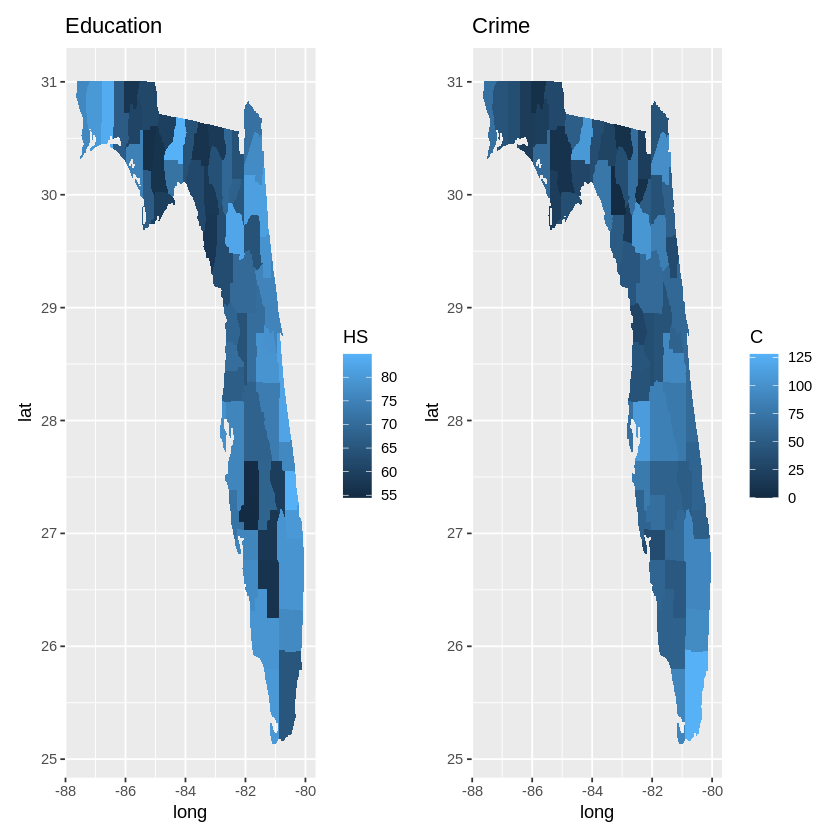

In [5]:
## Code for illustration purposes only
us_counties <- map_data("county")
florida_counties <- us_counties %>%
  filter(region == "florida")
crime_match <- crime %>%
  mutate(
    County = str_to_lower(str_replace_all(County, "\\.", ""))
  )
county_name_compat <- c(
  "washington" = "washing",
  "santa rosa" = "santar",
  "suwannee" = "suwanee",
  "palm beach" = "palmb",
  "okeechobee" = "okeech",
  "indian river" = "indianr",
  "hillsborough" = "hillsbor",
  "miami-dade" = "dade"
)
florida_crime <- florida_counties %>%
  mutate(
    County = dplyr::recode(subregion, !!!county_name_compat),
    County = str_replace_all(County, "\\s", "")
  ) %>%
  left_join(crime_match, by = "County")
p1 <- florida_crime %>%
  ggplot(aes(x = long, y = lat, group = group, fill = U)) +
  geom_polygon() +
  labs(
    title = "Urbanisation"
  )
p2 <- florida_crime %>%
  ggplot(aes(x = long, y = lat, group = group, fill = HS)) +
  geom_polygon() +
  labs(
    title = "Education"
  )
p3 <- florida_crime %>%
  ggplot(aes(x = long, y = lat, group = group, fill = C)) +
  geom_polygon() +
  labs(
    title = "Crime"
  )
p2 + p3


Variables description:

-   `C`: number of crimes per 100,000 inhabitants
-   `HS`: share of high school graduates
-   `U`: share of persons living in urban areas

## First model: crime and education

$$
\underbrace{C_i}_{\text{Crime}} = \beta_0 + \beta_1 \underbrace{\text{HS}_i}_{\text{Share of persons with high school degree}} + \underbrace{e_i}_{\text{Random term}}, \quad i = 1,\ldots,n = 67
$$

```{r}
#
# summary(fit_C_HS)
```

Estimated equation: $\hat{C}$: expected crime rate

$$
\hat{C}_i = -50.8 + 1.48 \text{HS}_i
$$

$$
\hat{C}_{HS = 80}  = -50.8 + 1.48 \cdot 80 = 67.6\\
\hat{C}_{HS = 50}  = -50.8 + 1.48 \cdot 50 = 23.2\\
$$

$$
\hat{C}_{HS = 80} - \hat{C}_{HS = 79} = -50.8 + 1.48 \cdot 80 - (-50.8 + 1.48 \cdot 79) = 1.48\cdot(80 - 79) = 1.48
$$

The constant in the model is the expected number of crimes (per 100,000 citizens) in a county where HS = 0.

```{r}
crime %>%
  ggplot(aes(x = HS, y = C)) +
    geom_point() +
    xlim(c(0, 100)) +
    ylim(c(-60, 120)) +
    geom_abline(intercept = -50.8, slope = 1.48) +
    geom_vline(xintercept = c(0, mean(crime$HS)), color = "steelblue", lty = 2)
```

Centered predictors (x-variables)

$$
C_i = \beta_0 + \beta_1 (\text{HS}_i - \overline{HS}) + e_i
$$

```{r}

```

$$
\hat{C}_i = 52.4 + 1.48 (\text{HS}_i - \overline{HS})
$$

### Predictions

Predict the crime rate in 3 hypothetical counties using the centered predictor model.

$$
\hat{C}_{HS = 0} = ? \\
\hat{C}_{HS = \overline{HS}} = ? \\
\hat{C}_{HS = 100} = ?
$$

Using the original (non-centered predictor) equation:

$$
\hat{C}_i = -50.8 + 1.48 \text{HS}_i
$$

$$
\hat{C}_{HS = 0} = -50.8\\
\hat{C}_{HS = \overline{HS}} = -50.8 + 1.48 \cdot 69.5 = 52.06 \\
\hat{C}_{HS = 100} = -50.8 + 1.48 \cdot 100 = 97.2
$$

Standard errors of predictions?

$$
SE(\hat{C}_{HS = 0}) = ?\\
SE(\hat{C}_{HS = \overline{HS}}) = ? \\
SE(\hat{C}_{HS = 100}) = ?
$$

## Second model: crime and urbanization

$$
C_i = \beta_0 + \beta_1 U_i + e_i
$$

```{r}
fit_U_HS <- lm(C ~ 1 + U, data = crime)
summary(fit_U_HS)
```

Initial expectation: more crime in more urbanized counties.

Estimated regression equation:

$$
\hat{C}_i = 24.5 + 0.56 U_i
$$

The coefficient of U is positive. This implies that expected crime rate $\hat{C}$ increases with increasing values of $U$ (degree of urbanization).

Homework: difference in expected crime rates for two counties with $U = 80$ and $U = 50$.

## Third Model: Education and Urbanization

$$
\text{HS}_i = \beta_0 + \beta_1 U_i + e_i
$$

```{r}
# Fit the model and print the summary

```

## Graphical representation of the data

```{r}
ggpairs(crime, columns = c(4, 3, 2), lower = list(continuous = "smooth"))
```

## Fourth Model: Crime, Education, and Urbanization

$$
C_i = \beta_0 + \beta_1 \text{HS}_i  + \beta_2 \text{U}_i + e_i
$$

```{r}
fit_C_U_HS <- lm(C ~ 1 + HS + U, data = crime)

## Print the summary

```

```{r}
# Use plotly to create a 3d scatter and a plane

# Create a grid of values for HS and U to calculate the predicted plane
grid_dt <- expand.grid(
  HS = seq(min(crime$HS), max(crime$HS), length.out = 30),
  U = seq(min(crime$U), max(crime$U), length.out = 30)
)
C_hat <- predict(fit_C_U_HS, newdata = grid)
C_hat_M <- matrix(C_hat, nrow=30, ncol=30, byrow=TRUE)

# Create the 3D scatter plot and regression plane
plot_ly() %>%
  add_markers(
    data = crime,
    x = ~HS,
    y = ~U,
    z = ~C,
    marker = list(size = 3),
    name = "Data points"
  )  %>%
  add_surface(
    data=grid_dt,
    x = ~unique(HS),
    y = ~unique(U),
    z = C_hat_M,
    colorscale = "Viridis",
    opacity = 0.7,
    name = "Regression plane"
  ) %>%
  layout(
    scene = list(
      xaxis = list(title = "HS (Education)"),
      yaxis = list(title = "U (Urbanization)"),
      zaxis = list(title = "C (Crime)")
    ),
    title = "3D Scatter Plot with Regression Plane"
  )
```


Estimated regression equation:

$$
\hat{C}_i = 59.1 -0.58 \text{HS}_i  + 0.68 \text{U}_i
$$

$$
\hat{C}_{HS = 80} = 59.1 - 0.58 \cdot 80 + 0.68 U = 12.4 + 0.68 U \\
\hat{C}_{HS = 50} = 59.1 - 0.58 \cdot 50 + 0.68 U = 29.93+ 0.68 U
$$

$$
\hat{C}_{HS = 80, U = 50} = 59.1 - 0.58 \cdot 80 + 0.68 U = 12.4 + 0.68 \cdot 50 = 46.4\\
\hat{C}_{HS = 50, U = 50} = 59.1 - 0.58 \cdot 50 + 0.68 U = 29.93+ 0.68 \cdot 50 = 63.9\\
\hat{C}_{HS = 80, U = 50} - \hat{C}_{HS = 50, U = 50} = 12.4 - 29.93 = -16.9 \approx -0.58 \cdot \underbrace{30}_{\Delta HS = 80 - 50} \quad \text{approx. due to rounding}
$$

Homework: compute the difference:

$$
\hat{C}_{HS = 80, U = 10} - \hat{C}_{HS = 50, U = 10} = ?
$$

```{r}
## First argument: model fit object from lm
# newdata = ?
# predict(..., newdata = newdata, se.fit = TRUE)
```

```{r}
## Documentation: uncomment the following line and run it
# ?predict.lm
```

```{r}
crime %>%
  ggplot(aes(x = HS, y = C)) +
    geom_point() +
    geom_smooth(method = "lm")
```

```{r}
crime %>%
  ggplot(aes(x = HS, y = C)) +
    geom_point() +
    geom_smooth(method = "lm")
```

## Hypothesis testing

$$
C_i = \beta_0 + \beta_1 \text{HS}_i  + \beta_2 \text{U}_i + e_i
$$

```{r}
# options(scipen = 1000000)
fit_U_HS <- lm(C ~ 1 + HS + U, data = crime)
summary(fit_U_HS)
```

$$
H_0: \beta_1 = 0 \\
H_1: \beta_1 \neq 0
$$

For a given level of urbanization, the number of crimes does not vary systematically with the share of residents with a school degree.

Distribution of the t-statistic under the null hypothesis:

$$
t \sim t(df = 67 - 3)
$$

Choose a significance level: 5% probability to falsely reject a true null hypothesis

```{r}
## alpha: error probability = 0.05
```

### p-value (two-sided alternative)

```{r}

```

## Linearity

Real structure:

$$
y_i = 3 + x^2 + u_i, \quad u_i \sim N(0, 500^2)
$$ $$
y_i = \beta_0 + \beta_1 x^2 + u_i, \quad u_i \sim N(0, 500^2)
$$ Example of a non-linear model

$$
y_i = \beta + \beta^2 x + u_i
$$

```{r}
dt <- tibble(
  x = (-100):100
) %>%
  mutate(
    y = 10000 + x ^ 2 + rnorm(n(), 0, 500)
  )
```

```{r}
dt %>%
  ggplot(aes(x = x, y = y)) +
    geom_point() +
    geom_abline(slope = -0.1944, intercept = 3309.5337)
 #    geom_smooth()
```

Fit a linear (in x) model to the data \$\$ y_i = \beta\_0 + \beta\_1 x_i + u_i

\$\$

```{r}
fit_xy <- lm(y ~ 1 + x, data = dt)
summary(fit_xy)
```

Fit a linear (in x) model to the data $$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + u_i
$$

```{r}
I("fgsdfsdf")
```

```{r}
fit_x2y <- lm(y ~ 1 + x + I(x ^ 2), data = dt)
summary(fit_x2y)
```

$$
y_i = 3 + 0\cdot x + x^2 + u_i, \quad u_i \sim N(0, 500^2)
$$

<!-- $$ -->

<!-- \hat{C}_i[\text{number of crimes}] = -50.8[\text{number of crimes}] + 1.48 \left[\frac{\text{number of crimes}}{\text{percentage points}}\right]\text{HS}_i[\text{percentage points}] -->

<!-- $$ -->

<!-- Interpretation (slope): comparing two counties: that differ by 1 percentage point on HS we expect the county with the higher HS to have 1.48 crimes more for 100,000 inhabitants. -->

<!-- Interpretation (intercept): -->

<!-- $$ -->

<!-- \hat{C}_{HS} = -50.8 + 1.48 HS\\ -->

<!-- \hat{C}_{HS = 0} = -50.8 -->

<!-- $$ -->

<!-- $$ -->

<!-- f(x) = -50.8 + 1.48x\\ -->

<!-- f(0) = -50.8 -->

<!-- $$ -->

<!-- $$ -->

<!-- \overline{HS} = \frac{1}{n}\sum_{i = 1}^{n} HS_i\\ -->

<!-- C_i = \alpha + \beta (\text{HS}_i - \overline{HS}) + e_i\\ -->

<!-- $$ -->

<!-- ```{r} -->

<!-- crime %>% -->

<!--   ggplot(aes(x = HS, y = C)) + -->

<!--     geom_point() +  -->

<!--     geom_smooth(method = "lm") + -->

<!--     geom_abline(intercept = -50.8, slope = 1.48) + -->

<!--     labs( -->

<!--       x = "HS: Percentage of persons with high school degree", -->

<!--       y = "C: Crime rate" -->

<!--     ) + -->

<!--     scale_x_continuous(breaks = c(55, 60, 70, 80, 85)) + -->

<!--     xlim(c(0, 90)) + -->

<!--     ylim(c(-55, 140))  + -->

<!--      geom_vline(xintercept = 0, lty = 2) + -->

<!--      geom_vline(xintercept = 69.49, lty = 2) -->

<!-- ``` -->

<!-- ```{r} -->

<!-- crime %>% -->

<!--   ggplot(aes(x = U, y = HS)) + -->

<!--     geom_point() + -->

<!--     geom_smooth(method = "lm") -->

<!-- ``` -->

<!-- ```{r} -->

<!-- ## Average value of HS: 69.48 percent -->

<!-- mean(crime$HS) -->

<!-- crime <- crime %>% -->

<!--   mutate( -->

<!--     HS_centered = HS - mean(HS) -->

<!--   ) -->

<!-- ``` -->

<!-- ```{r} -->

<!-- fit_HS_centered <- lm(C ~ HS_centered, data = crime) -->

<!-- summary(fit_HS_centered) -->

<!-- # summary(crime$HS) -->

<!-- # summary(crime$HS_centered) -->

<!-- ``` -->

<!-- $$ -->

<!-- \hat{C}_i = 52.4 + 1.48 (HS_i - \overline{HS})\\ -->

<!-- \hat{C}_i = 52.4 + 1.48 (HS_i - 69.48)\\ -->

<!-- $$ -->

<!-- $$ -->

<!-- \hat{C}_{HS = \overline{HS}} = 52.4 -->

<!-- $$ -->

<!-- Expected crime rate in a county with the average share of high school graduates. -->

<!-- $$ -->

<!-- \underbrace{C_i}_{Crime} = \alpha + \beta \underbrace{\text{U}_i}_{\text{Share of persons in urban areas}} + e_i -->

<!-- $$ -->

<!-- Predictions: -->

<!-- ```{r} -->

<!-- ## Prediction with the original model C ~ HS -->

<!-- newdata_hs0 <- data.frame(HS = 0) -->

<!-- # ?predict.lm -->

<!-- predict(fit, newdata = newdata_hs0, se.fit = TRUE) -->

<!-- ``` -->

<!-- $$ -->

<!-- \hat{C}_{HS} = -50.85 + 1.48 HS\\ -->

<!-- \hat{C}_{HS = 0} = -50.85 -->

<!-- $$ -->

<!-- ```{r} -->

<!-- ## Average HS = 69.49 -->

<!-- predict(fit, newdata = data.frame(HS = 69.49), se.fit = TRUE) -->

<!-- ``` -->

<!-- $$ -->

<!-- \hat{C}_{HS = \overline{HS}} = 52.40365 -->

<!-- $$ -->

<!-- ```{r} -->

<!-- newdata_multiple_values <- data.frame(HS = c(40, 50, 69, 80, 100)) -->

<!-- # newdata_multiple_values <- data.frame(HS = c(69)) -->

<!-- predict(fit, newdata = newdata_multiple_values, se.fit = TRUE, interval = "confidence") -->

<!-- ``` -->

<!-- $$ -->

<!-- \hat{C}_{HS = 100} = 97.74081 -->

<!-- $$ -->

<!-- Interpretation: counties that differ by one percentage point (the unit of U) on U are expected to differ by 0.56 cimes per 100,000 inhabitants. Counties with higher degree of urbanisation are expected to have higher crime rates. -->

<!-- ```{r} -->

<!-- crime %>% -->

<!--   select(C, HS, U) %>% -->

<!--   pairs() -->

<!-- ``` -->